# Image classification via fine-tuning with EfficientNet

## Introduction: what is EfficientNet

EfficientNet, first introduced in [Tan and Le, 2019](https://arxiv.org/abs/1905.11946)
is among the most efficient models (i.e. requiring least FLOPS for inference)
that reaches State-of-the-Art accuracy on both
imagenet and common image classification transfer learning tasks.

The smallest base model is similar to [MnasNet](https://arxiv.org/abs/1807.11626), which
reached near-SOTA with a significantly smaller model. By introducing a heuristic way to
scale the model, EfficientNet provides a family of models (B0 to B7) that represents a
good combination of efficiency and accuracy on a variety of scales. Such a scaling
heuristics (compound-scaling, details see
[Tan and Le, 2019](https://arxiv.org/abs/1905.11946)) allows the
efficiency-oriented base model (B0) to surpass models at every scale, while avoiding
extensive grid-search of hyperparameters.

A summary of the latest updates on the model is available at
[here](https://github.com/pytorch/vision/blob/main/torchvision/models/efficientnet.py), where various
augmentation schemes and semi-supervised learning approaches are applied to further
improve the imagenet performance of the models. These extensions of the model can be used
by updating weights without changing model architecture.

## B0 to B7 variants of EfficientNet

*(This section provides some details on "compound scaling", and can be skipped
if you're only interested in using the models)*

Based on the [original paper](https://arxiv.org/abs/1905.11946) people may have the
impression that EfficientNet is a continuous family of models created by arbitrarily
choosing scaling factor in as Eq.(3) of the paper.  However, choice of resolution,
depth and width are also restricted by many factors:

- Resolution: Resolutions not divisible by 8, 16, etc. cause zero-padding near boundaries
of some layers which wastes computational resources. This especially applies to smaller
variants of the model, hence the input resolution for B0 and B1 are chosen as 224 and
240.

- Depth and width: The building blocks of EfficientNet demands channel size to be
multiples of 8.

- Resource limit: Memory limitation may bottleneck resolution when depth
and width can still increase. In such a situation, increasing depth and/or
width but keep resolution can still improve performance.

As a result, the depth, width and resolution of each variant of the EfficientNet models
are hand-picked and proven to produce good results, though they may be significantly
off from the compound scaling formula.
Therefore, the Pytorch implementation (detailed below) only provide these 8 models, B0 to B7,
instead of allowing arbitray choice of width / depth / resolution parameters.

## Pytorch implementation of EfficientNet

An implementation of EfficientNet B0 to B7 has been shipped with Pytorch. To
use EfficientNetB0 for classifying 1000 classes of images from ImageNet, run:

```python
import torch.nn as nn
from torchvision.models import efficientnet_b0
model = efficientnet_b0(weights="DEFAULT")
```

This model takes input images of shape `(224, 224, 3)`, and the input data should be in the
range `[0, 255]`. Normalization is included as part of the model.

Because training EfficientNet on ImageNet takes a tremendous amount of resources and
several techniques that are not a part of the model architecture itself. Hence the Pytorch
implementation by default loads pre-trained weights.

For B0 to B7 base models, the input shapes are different. Here is a list of input shape
expected for each model:

| Base model | resolution|
|----------------|-----|
| EfficientNetB0 | 224 |
| EfficientNetB1 | 240 |
| EfficientNetB2 | 260 |
| EfficientNetB3 | 300 |
| EfficientNetB4 | 380 |
| EfficientNetB5 | 456 |
| EfficientNetB6 | 528 |
| EfficientNetB7 | 600 |

When the model is intended for transfer learning, the Pytorch implementation
provides a option to remove the top layers:
```python
model = efficientnet_b0(weights="DEFAULT")
top_dropout_rate = 0.2
model.classifier = nn.Sequential(
        nn.Dropout(top_dropout_rate),
        nn.Linear(model.classifier[1].in_features, num_classes),
        nn.Softmax(dim=1)
    )
```
This option excludes the `classifier` that turns 1280 features on the penultimate
layer into prediction of the 1000 ImageNet classes. Replacing the top layer with custom
layers allows using EfficientNet as a feature extractor in a transfer learning workflow.

## Example: EfficientNetB0 for Stanford Dogs.

EfficientNet is capable of a wide range of image classification tasks.
This makes it a good model for transfer learning.
As an end-to-end example, we will show using pre-trained EfficientNetB0 on
[Stanford Dogs](http://vision.stanford.edu/aditya86/ImageNetDogs/main.html) dataset.

## Setup and data loading

In [1]:
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import os

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 64

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

### Loading data

Stanford Dogs dataset is provided [stanford_dogs](http://vision.stanford.edu/aditya86/ImageNetDogs).
It features 20,580 images that belong to 120 classes of dog breeds.

When the images are much smaller than the size of EfficientNet input,
we can simply upsample the input images. It has been shown in
[Tan and Le, 2019](https://arxiv.org/abs/1905.11946) that transfer learning
result is better for increased resolution even if input images remain small.

In [2]:
import os
import requests
import tarfile

# Dataset parameters
dataset_name = "stanford_dogs"

# Define the dataset URL and local paths
dataset_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
dataset_tar_path = "./stanford_dogs.tar"
extract_path = "./stanford_dogs"
# Define paths
data_dir = "./stanford_dogs/Images"  # Path to the "Images" folder

# Download the dataset if it doesn't exist
if not os.path.exists(dataset_tar_path):
    print("Downloading dataset...")
    response = requests.get(dataset_url, stream=True)
    with open(dataset_tar_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("Download complete!")

# Extract the TAR file
if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with tarfile.open(dataset_tar_path, "r") as tar:
        tar.extractall(path=extract_path)
    print("Extraction complete!")

# Verify the extracted contents
print("Extracted files:", os.listdir(extract_path))

Extracted files: ['stanford_dogs', 'Images', 'downloads']


When the dataset include images with various size, we need to resize them into a
shared size. The Stanford Dogs dataset includes only images at least 200x200
pixels in size. Here we resize the images to the input size needed for EfficientNet.

In [3]:
# Define transformations to resize and preprocess images
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Create DataLoaders for batching
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Get the number of classes
NUM_CLASSES = len(dataset.classes)
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 120


### Visualizing the data

The following code shows the first 9 images with their labels.

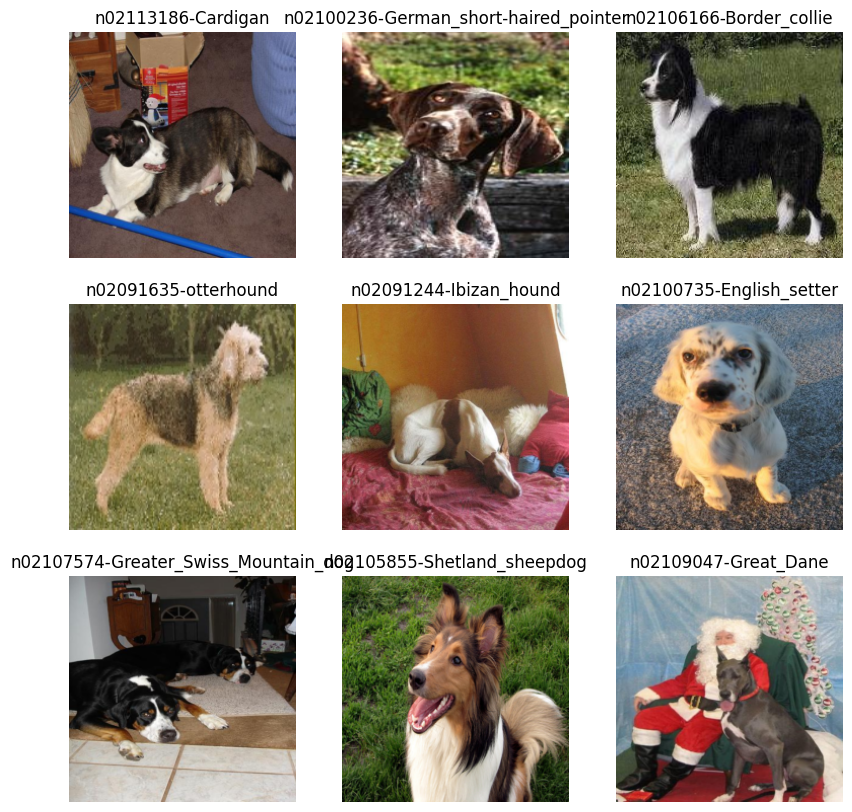

In [4]:
from torchvision.transforms.functional import to_pil_image

# Get class labels from the dataset
class_names = dataset.classes  # Automatically inferred from folder names

# Function to display a batch of images
def show_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = to_pil_image(images[i])  # Convert tensor to PIL image
        plt.imshow(image)
        plt.title(class_names[labels[i].item()])  # Convert label index to class name
        plt.axis("off")
    plt.show()

# Get a batch of images and labels
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Visualize the first 9 images
show_images(images, labels)

### Data augmentation

We can use the transforms module for image augmentation.

In [5]:
# Define the augmentation transformations
img_augmentation = transforms.Compose([
    transforms.RandomRotation(degrees=0.15*360),  # Random rotation within ±15% * 360 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip with 50% probability
    transforms.RandomVerticalFlip(p=0.5), # Random vertical flip with 50% probability
    transforms.ColorJitter(contrast=0.1)  # Random contrast adjustment
])

This `Compose` object can be used both as a part of
the model we later build, and as a function to preprocess
data before feeding into the model. Using them as function makes
it easy to visualize the augmented images. Here we plot 9 examples
of augmentation result of a given figure.

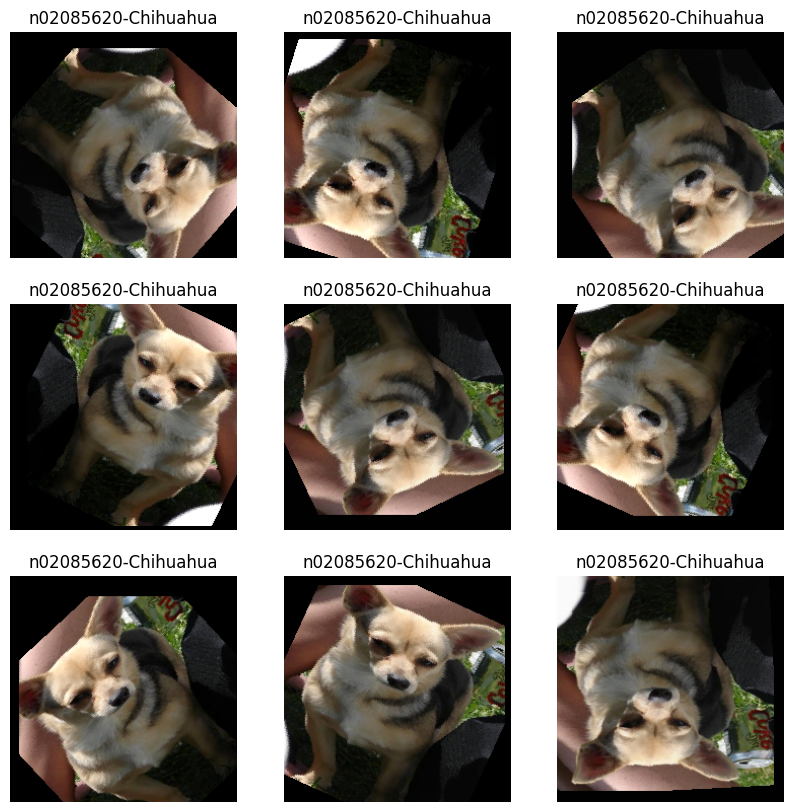

In [6]:
# Define a function to visualize augmented images
def visualize_augmentations(image, class_label, num_examples=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_examples):
        ax = plt.subplot(3, 3, i + 1)

        # Apply augmentations
        aug_img = img_augmentation(image)

        # Convert tensor to PIL image for visualization
        plt.imshow(to_pil_image(aug_img))
        plt.title(f"{class_label}")
        plt.axis("off")
    plt.show()

# Get one image and its label from the dataset
image, label = dataset[0]  # Example: First image in the training dataset

# Visualize augmentations
visualize_augmentations(image, class_names[label])

### Prepare inputs

Once we verify the input data and augmentation are working correctly,
we prepare dataset for training. The input data are resized to uniform
`IMG_SIZE`. The labels are put into one-hot
(a.k.a. categorical) encoding. The dataset is batched.

In [10]:
# Training transformations (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize images to uniform size
    transforms.RandomRotation(degrees=0.15*360),  # Random rotation within ±15% * 360 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip with 50% probability
    transforms.RandomVerticalFlip(p=0.5), # Random vertical flip with 50% probability
    transforms.ColorJitter(contrast=0.1),  # Random contrast adjustment
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Testing transformations (without augmentation)
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize images to uniform size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load the dataset without initial transformations
dataset = datasets.ImageFolder(root=data_dir)

# Split the dataset into training and testing subsets
train_size = int(0.8 * len(dataset))  # 80% training data
test_size = len(dataset) - train_size
train_indices, test_indices = torch.utils.data.random_split(range(len(dataset)), [train_size, test_size])

# Apply the corresponding transformations using Subset
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Assign specific transformations for training and testing datasets
train_dataset.dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
test_dataset.dataset = datasets.ImageFolder(root=data_dir, transform=test_transform)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Check dataset info
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 16464
Number of testing samples: 4116


## Training a model from scratch

We build an EfficientNetB0 with 120 output classes, that is initialized from scratch:

Note: the accuracy will increase very slowly and may overfit.

In [11]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b0
from tqdm import tqdm
from torchsummary import summary

# Load EfficientNetB0 without pre-trained weights
model = efficientnet_b0(weights=None)

# Modify the final classification layer to match the number of classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Learning rate = 0.001

# Display the model summary
input_shape = (3, IMG_SIZE, IMG_SIZE)
summary(model, input_size=input_shape)

# Number of epochs
epochs = 40

# Initialize history dictionary to store metrics
history = {
    "train_accuracy": [],
    "train_loss": [],
    "val_accuracy": [],
    "val_loss": []
}

# Training loop with metric logging
for epoch in range(epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = outputs.max(1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_loader)

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = outputs.max(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(test_loader)

    # Log metrics for plotting
    history["train_accuracy"].append(train_accuracy)
    history["train_loss"].append(train_loss)
    history["val_accuracy"].append(val_accuracy)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

Epoch 1/40: 100%|██████████| 258/258 [04:54<00:00,  1.14s/it]


Epoch 1/40
Train Loss: 4.7000, Train Accuracy: 0.0193
Val Loss: 4.6004, Val Accuracy: 0.0243


Epoch 2/40: 100%|██████████| 258/258 [03:09<00:00,  1.36it/s]


Epoch 2/40
Train Loss: 4.4425, Train Accuracy: 0.0286
Val Loss: 4.4299, Val Accuracy: 0.0296


Epoch 3/40: 100%|██████████| 258/258 [03:10<00:00,  1.35it/s]


Epoch 3/40
Train Loss: 4.3271, Train Accuracy: 0.0377
Val Loss: 4.2903, Val Accuracy: 0.0396


Epoch 4/40: 100%|██████████| 258/258 [03:02<00:00,  1.41it/s]


Epoch 4/40
Train Loss: 4.1830, Train Accuracy: 0.0528
Val Loss: 4.0859, Val Accuracy: 0.0666


Epoch 5/40: 100%|██████████| 258/258 [03:53<00:00,  1.10it/s]


Epoch 5/40
Train Loss: 4.0263, Train Accuracy: 0.0610
Val Loss: 4.1293, Val Accuracy: 0.0673


Epoch 6/40: 100%|██████████| 258/258 [03:43<00:00,  1.15it/s]


Epoch 6/40
Train Loss: 3.9240, Train Accuracy: 0.0753
Val Loss: 3.8989, Val Accuracy: 0.0777


Epoch 7/40: 100%|██████████| 258/258 [02:58<00:00,  1.44it/s]


Epoch 7/40
Train Loss: 3.7997, Train Accuracy: 0.0921
Val Loss: 3.7344, Val Accuracy: 0.1013


Epoch 8/40: 100%|██████████| 258/258 [02:58<00:00,  1.44it/s]


Epoch 8/40
Train Loss: 3.6818, Train Accuracy: 0.1127
Val Loss: 3.7372, Val Accuracy: 0.1052


Epoch 9/40: 100%|██████████| 258/258 [03:00<00:00,  1.43it/s]


Epoch 9/40
Train Loss: 3.5616, Train Accuracy: 0.1228
Val Loss: 3.6177, Val Accuracy: 0.1283


Epoch 10/40: 100%|██████████| 258/258 [04:45<00:00,  1.11s/it]


Epoch 10/40
Train Loss: 3.4545, Train Accuracy: 0.1467
Val Loss: 3.5479, Val Accuracy: 0.1441


Epoch 11/40: 100%|██████████| 258/258 [02:59<00:00,  1.44it/s]


Epoch 11/40
Train Loss: 3.3569, Train Accuracy: 0.1655
Val Loss: 3.3300, Val Accuracy: 0.1696


Epoch 12/40: 100%|██████████| 258/258 [02:59<00:00,  1.44it/s]


Epoch 12/40
Train Loss: 3.2534, Train Accuracy: 0.1800
Val Loss: 3.2118, Val Accuracy: 0.1868


Epoch 13/40: 100%|██████████| 258/258 [02:55<00:00,  1.47it/s]


Epoch 13/40
Train Loss: 3.1496, Train Accuracy: 0.2038
Val Loss: 3.1207, Val Accuracy: 0.2075


Epoch 14/40: 100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


Epoch 14/40
Train Loss: 3.0538, Train Accuracy: 0.2196
Val Loss: 3.1248, Val Accuracy: 0.2199


Epoch 15/40: 100%|██████████| 258/258 [03:45<00:00,  1.14it/s]


Epoch 15/40
Train Loss: 2.9789, Train Accuracy: 0.2352
Val Loss: 3.0515, Val Accuracy: 0.2330


Epoch 16/40: 100%|██████████| 258/258 [02:57<00:00,  1.45it/s]


Epoch 16/40
Train Loss: 2.8837, Train Accuracy: 0.2553
Val Loss: 2.9206, Val Accuracy: 0.2485


Epoch 17/40: 100%|██████████| 258/258 [02:58<00:00,  1.44it/s]


Epoch 17/40
Train Loss: 2.8018, Train Accuracy: 0.2712
Val Loss: 2.9032, Val Accuracy: 0.2539


Epoch 18/40: 100%|██████████| 258/258 [02:57<00:00,  1.45it/s]


Epoch 18/40
Train Loss: 2.7161, Train Accuracy: 0.2847
Val Loss: 2.9384, Val Accuracy: 0.2595


Epoch 19/40: 100%|██████████| 258/258 [04:05<00:00,  1.05it/s]


Epoch 19/40
Train Loss: 2.6607, Train Accuracy: 0.2993
Val Loss: 2.7486, Val Accuracy: 0.2874


Epoch 20/40: 100%|██████████| 258/258 [02:58<00:00,  1.44it/s]


Epoch 20/40
Train Loss: 2.5739, Train Accuracy: 0.3134
Val Loss: 2.7235, Val Accuracy: 0.2979


Epoch 21/40: 100%|██████████| 258/258 [02:59<00:00,  1.44it/s]


Epoch 21/40
Train Loss: 2.5163, Train Accuracy: 0.3235
Val Loss: 2.6948, Val Accuracy: 0.2981


Epoch 22/40: 100%|██████████| 258/258 [02:58<00:00,  1.45it/s]


Epoch 22/40
Train Loss: 2.4507, Train Accuracy: 0.3372
Val Loss: 2.7563, Val Accuracy: 0.2928


Epoch 23/40: 100%|██████████| 258/258 [03:54<00:00,  1.10it/s]


Epoch 23/40
Train Loss: 2.3906, Train Accuracy: 0.3480
Val Loss: 2.6695, Val Accuracy: 0.3205


Epoch 24/40: 100%|██████████| 258/258 [03:39<00:00,  1.17it/s]


Epoch 24/40
Train Loss: 2.3304, Train Accuracy: 0.3610
Val Loss: 2.6348, Val Accuracy: 0.3151


Epoch 25/40: 100%|██████████| 258/258 [02:59<00:00,  1.43it/s]


Epoch 25/40
Train Loss: 2.2730, Train Accuracy: 0.3783
Val Loss: 2.5672, Val Accuracy: 0.3321


Epoch 26/40: 100%|██████████| 258/258 [02:59<00:00,  1.44it/s]


Epoch 26/40
Train Loss: 2.2081, Train Accuracy: 0.3942
Val Loss: 2.5561, Val Accuracy: 0.3387


Epoch 27/40: 100%|██████████| 258/258 [03:58<00:00,  1.08it/s]


Epoch 27/40
Train Loss: 2.1441, Train Accuracy: 0.4065
Val Loss: 2.5937, Val Accuracy: 0.3270


Epoch 28/40: 100%|██████████| 258/258 [03:53<00:00,  1.10it/s]


Epoch 28/40
Train Loss: 2.1010, Train Accuracy: 0.4141
Val Loss: 2.4791, Val Accuracy: 0.3608


Epoch 29/40: 100%|██████████| 258/258 [02:59<00:00,  1.44it/s]


Epoch 29/40
Train Loss: 2.0474, Train Accuracy: 0.4326
Val Loss: 2.4695, Val Accuracy: 0.3613


Epoch 30/40: 100%|██████████| 258/258 [03:27<00:00,  1.24it/s]


Epoch 30/40
Train Loss: 1.9837, Train Accuracy: 0.4489
Val Loss: 2.5066, Val Accuracy: 0.3608


Epoch 31/40: 100%|██████████| 258/258 [04:00<00:00,  1.07it/s]


Epoch 31/40
Train Loss: 1.9338, Train Accuracy: 0.4549
Val Loss: 2.5174, Val Accuracy: 0.3642


Epoch 32/40: 100%|██████████| 258/258 [04:19<00:00,  1.01s/it]


Epoch 32/40
Train Loss: 1.8854, Train Accuracy: 0.4625
Val Loss: 2.3890, Val Accuracy: 0.3819


Epoch 33/40: 100%|██████████| 258/258 [03:27<00:00,  1.24it/s]


Epoch 33/40
Train Loss: 1.8217, Train Accuracy: 0.4793
Val Loss: 2.5100, Val Accuracy: 0.3652


Epoch 34/40: 100%|██████████| 258/258 [03:30<00:00,  1.22it/s]


Epoch 34/40
Train Loss: 1.7873, Train Accuracy: 0.4938
Val Loss: 2.5165, Val Accuracy: 0.3751


Epoch 35/40: 100%|██████████| 258/258 [04:25<00:00,  1.03s/it]


Epoch 35/40
Train Loss: 1.7353, Train Accuracy: 0.5027
Val Loss: 2.5130, Val Accuracy: 0.3693


Epoch 36/40: 100%|██████████| 258/258 [04:19<00:00,  1.00s/it]


Epoch 36/40
Train Loss: 1.6843, Train Accuracy: 0.5104
Val Loss: 2.3369, Val Accuracy: 0.4067


Epoch 37/40: 100%|██████████| 258/258 [03:30<00:00,  1.23it/s]


Epoch 37/40
Train Loss: 1.6387, Train Accuracy: 0.5218
Val Loss: 2.4240, Val Accuracy: 0.3868


Epoch 38/40: 100%|██████████| 258/258 [03:33<00:00,  1.21it/s]


Epoch 38/40
Train Loss: 1.5926, Train Accuracy: 0.5357
Val Loss: 2.4471, Val Accuracy: 0.3851


Epoch 39/40: 100%|██████████| 258/258 [04:18<00:00,  1.00s/it]


Epoch 39/40
Train Loss: 1.5353, Train Accuracy: 0.5478
Val Loss: 2.4108, Val Accuracy: 0.3977


Epoch 40/40: 100%|██████████| 258/258 [04:21<00:00,  1.01s/it]


Epoch 40/40
Train Loss: 1.4920, Train Accuracy: 0.5603
Val Loss: 2.5059, Val Accuracy: 0.3904


Training the model is relatively fast. This might make it sounds easy to simply train EfficientNet on any
dataset wanted from scratch. However, training EfficientNet on smaller datasets,
especially those with lower resolution like CIFAR-100, faces the significant challenge of
overfitting.

Hence training from scratch requires very careful choice of hyperparameters and is
difficult to find suitable regularization. It would also be much more demanding in resources.
Plotting the training and validation accuracy
makes it clear that validation accuracy stagnates at a low value.

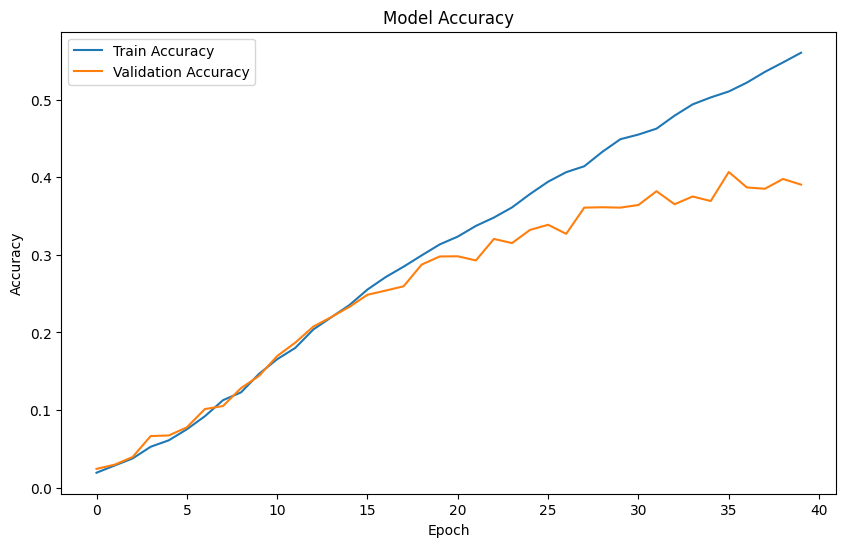

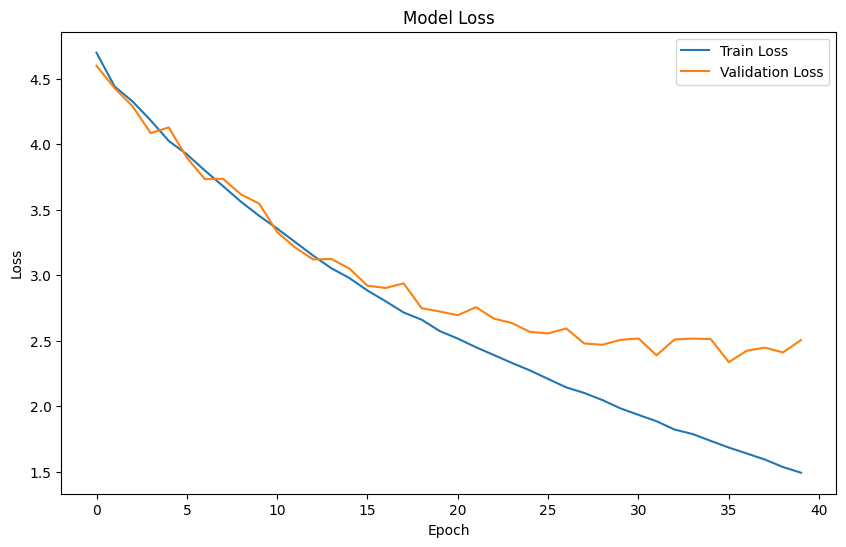

In [12]:
def plot_history(history):
    plt.figure(figsize=(10, 6))

    # Plot accuracy
    plt.plot(history["train_accuracy"], label="Train Accuracy")
    plt.plot(history["val_accuracy"], label="Validation Accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Call the function to plot
plot_history(history)

## Transfer learning from pre-trained weights

Here we initialize the model with pre-trained ImageNet weights,
and we fine-tune it on our own dataset.

In [315]:
# Define the model with transfer learning
def build_model(num_classes, weights="DEFAULT"):
    # Load pre-trained EfficientNetB0
    model = efficientnet_b0(weights=weights)

    # Freeze the pre-trained weights
    for param in model.features.parameters():
        param.requires_grad = False

    # Rebuild the classifier
    top_dropout_rate = 0.2
    model.classifier = nn.Sequential(
        nn.BatchNorm1d(1280),  # Number of features in EfficientNetB0
        nn.Dropout(top_dropout_rate),  # Dropout for regularization
        nn.Linear(model.classifier[1].in_features, num_classes),  # Update for num_classes
    )

    return model

# Create the model
model = build_model(NUM_CLASSES).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Handles multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  # Learning rate = 0.01

In [316]:
# Display the model summary
input_shape = (3, IMG_SIZE, IMG_SIZE)
summary(model, input_size=input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

The first step to transfer learning is to freeze all layers and train only the top
layers. For this step, a relatively large learning rate (1e-2) can be used.
Note that validation accuracy and loss will usually be better than training
accuracy and loss. This is because the regularization is strong, which only
suppresses training-time metrics.

Note that the convergence may take up to 50 epochs depending on choice of learning rate.

In [317]:
# Training loop
epochs = 25
history= {
    "train_accuracy": [],
    "train_loss": [],
    "val_accuracy": [],
    "val_loss": []
}

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct = 0
    total = 0

    # Training step
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        train_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    train_loss /= len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    val_loss /= len(test_loader)

    # Log metrics
    history["train_accuracy"].append(train_accuracy)
    history["train_loss"].append(train_loss)
    history["val_accuracy"].append(val_accuracy)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/25:   5%|▌         | 14/258 [00:17<03:54,  1.04it/s]

Epoch 1/25
Train Loss: 3.6829, Train Accuracy: 0.2885
Val Loss: 1.7650, Val Accuracy: 0.5428


Epoch 2/25: 100%|██████████| 258/258 [05:23<00:00,  1.25s/it]


Epoch 2/25
Train Loss: 2.3081, Train Accuracy: 0.4211
Val Loss: 1.6217, Val Accuracy: 0.5746


Epoch 3/25: 100%|██████████| 258/258 [04:59<00:00,  1.16s/it]


Epoch 3/25
Train Loss: 2.1577, Train Accuracy: 0.4442
Val Loss: 1.5743, Val Accuracy: 0.5826


Epoch 4/25: 100%|██████████| 258/258 [05:19<00:00,  1.24s/it]


Epoch 4/25
Train Loss: 2.0853, Train Accuracy: 0.4608
Val Loss: 1.5686, Val Accuracy: 0.5663


Epoch 5/25: 100%|██████████| 258/258 [05:23<00:00,  1.25s/it]


Epoch 5/25
Train Loss: 2.0656, Train Accuracy: 0.4670
Val Loss: 1.5823, Val Accuracy: 0.5797


Epoch 6/25: 100%|██████████| 258/258 [05:11<00:00,  1.21s/it]


Epoch 6/25
Train Loss: 2.0413, Train Accuracy: 0.4713
Val Loss: 1.6577, Val Accuracy: 0.5700


Epoch 7/25: 100%|██████████| 258/258 [05:27<00:00,  1.27s/it]


Epoch 7/25
Train Loss: 2.0300, Train Accuracy: 0.4733
Val Loss: 1.6081, Val Accuracy: 0.5751


Epoch 8/25: 100%|██████████| 258/258 [05:09<00:00,  1.20s/it]


Epoch 8/25
Train Loss: 2.0230, Train Accuracy: 0.4739
Val Loss: 1.6220, Val Accuracy: 0.5588


Epoch 9/25: 100%|██████████| 258/258 [05:39<00:00,  1.32s/it]


Epoch 9/25
Train Loss: 2.0110, Train Accuracy: 0.4791
Val Loss: 1.5672, Val Accuracy: 0.5826


Epoch 10/25: 100%|██████████| 258/258 [05:34<00:00,  1.30s/it]


Epoch 10/25
Train Loss: 2.0028, Train Accuracy: 0.4789
Val Loss: 1.5697, Val Accuracy: 0.5807


Epoch 11/25: 100%|██████████| 258/258 [04:54<00:00,  1.14s/it]


Epoch 11/25
Train Loss: 2.0326, Train Accuracy: 0.4775
Val Loss: 1.5613, Val Accuracy: 0.5877


Epoch 12/25: 100%|██████████| 258/258 [05:18<00:00,  1.23s/it]


Epoch 12/25
Train Loss: 2.0105, Train Accuracy: 0.4808
Val Loss: 1.6210, Val Accuracy: 0.5746


Epoch 13/25: 100%|██████████| 258/258 [05:10<00:00,  1.20s/it]


Epoch 13/25
Train Loss: 2.0045, Train Accuracy: 0.4783
Val Loss: 1.5883, Val Accuracy: 0.5850


Epoch 14/25: 100%|██████████| 258/258 [04:48<00:00,  1.12s/it]


Epoch 14/25
Train Loss: 2.0129, Train Accuracy: 0.4789
Val Loss: 1.6053, Val Accuracy: 0.5775


Epoch 15/25:  73%|███████▎  | 189/258 [04:03<01:28,  1.28s/it]

Epoch 15/25
Train Loss: 2.0149, Train Accuracy: 0.4789
Val Loss: 1.5661, Val Accuracy: 0.5904


Epoch 16/25: 100%|██████████| 258/258 [05:11<00:00,  1.21s/it]


Epoch 16/25
Train Loss: 2.0129, Train Accuracy: 0.4828
Val Loss: 1.5891, Val Accuracy: 0.5770


Epoch 17/25: 100%|██████████| 258/258 [06:17<00:00,  1.46s/it]


Epoch 17/25
Train Loss: 2.0034, Train Accuracy: 0.4827
Val Loss: 1.5522, Val Accuracy: 0.5935


Epoch 18/25: 100%|██████████| 258/258 [06:15<00:00,  1.46s/it]


Epoch 18/25
Train Loss: 2.0040, Train Accuracy: 0.4907
Val Loss: 1.6427, Val Accuracy: 0.5680


Epoch 19/25: 100%|██████████| 258/258 [06:14<00:00,  1.45s/it]


Epoch 19/25
Train Loss: 2.0154, Train Accuracy: 0.4858
Val Loss: 1.6268, Val Accuracy: 0.5654


Epoch 20/25:  29%|██▉       | 76/258 [02:01<06:19,  2.09s/it]

Epoch 20/25
Train Loss: 2.0150, Train Accuracy: 0.4865
Val Loss: 1.6171, Val Accuracy: 0.5858


Epoch 21/25:  95%|█████████▍| 244/258 [06:09<00:18,  1.35s/it]

Epoch 21/25
Train Loss: 2.0008, Train Accuracy: 0.4886
Val Loss: 1.5996, Val Accuracy: 0.5743


Epoch 22/25: 100%|██████████| 258/258 [06:31<00:00,  1.52s/it]


Epoch 22/25
Train Loss: 2.0222, Train Accuracy: 0.4802
Val Loss: 1.6560, Val Accuracy: 0.5656


Epoch 23/25: 100%|██████████| 258/258 [06:27<00:00,  1.50s/it]


Epoch 23/25
Train Loss: 2.0125, Train Accuracy: 0.4890
Val Loss: 1.6665, Val Accuracy: 0.5717


Epoch 24/25: 100%|██████████| 258/258 [04:58<00:00,  1.16s/it]


Epoch 24/25
Train Loss: 2.0345, Train Accuracy: 0.4847
Val Loss: 1.6490, Val Accuracy: 0.5768


Epoch 25/25: 100%|██████████| 258/258 [05:49<00:00,  1.35s/it]


Epoch 25/25
Train Loss: 2.0522, Train Accuracy: 0.4780
Val Loss: 1.6280, Val Accuracy: 0.5719


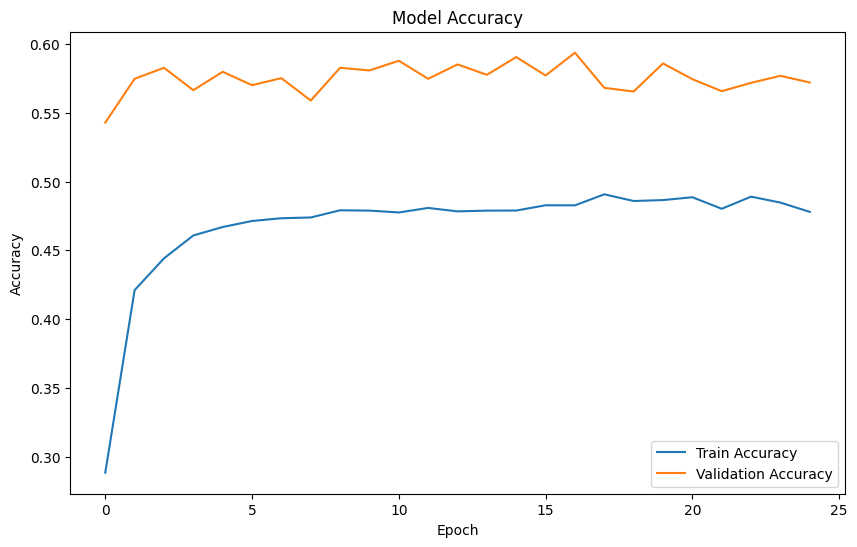

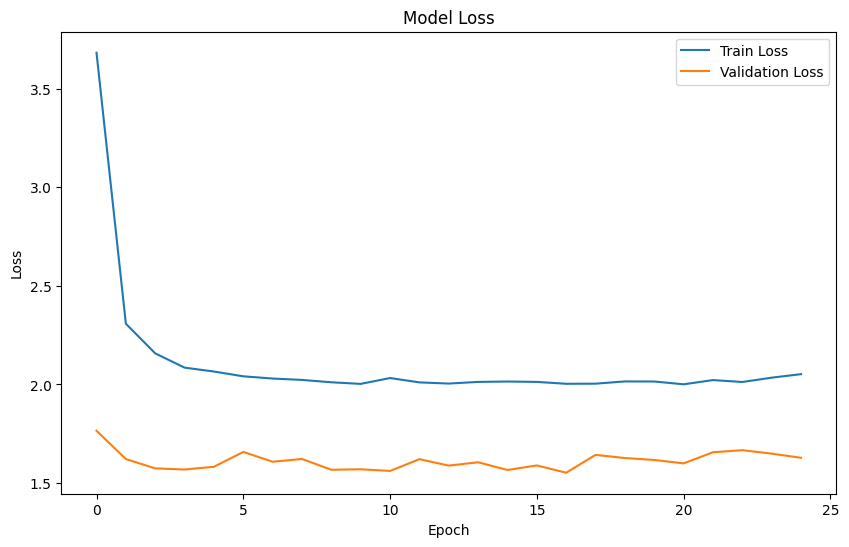

In [318]:
# Plot metrics
plot_history(history)

The second step is to unfreeze a number of layers and fit the model using smaller
learning rate. In this example we show unfreezing all layers, but depending on
specific dataset it may be desireble to only unfreeze a fraction of all layers.

When the feature extraction with
pretrained model works good enough, this step would give a very limited gain on
validation accuracy. In our case we only see a small improvement,
as ImageNet pretraining already exposed the model to a good amount of dogs.

On the other hand, when we use pretrained weights on a dataset that is more different
from ImageNet, this fine-tuning step can be crucial as the feature extractor also
needs to be adjusted by a considerable amount. Such a situation can be demonstrated
if choosing CIFAR-100 dataset instead, where fine-tuning boosts validation accuracy
by about 10% to pass 80% on `efficientnet_b0`.

A side note on freezing/unfreezing models: setting `param.requires_grad` of a `model.named_parameters` will
simultaneously set all parameters belonging to the `model.named_parameters` to the same `param.requires_grad`
attribute. Hence when we need to partially freeze/unfreeze
a model, we need to make sure the `param.requires_grad` attribute of the model is set
to `True`.

In [319]:
# Unfreeze the top layers of the model while leaving BatchNorm layers frozen
def unfreeze_model(model, num_classes, num_layers_to_unfreeze, weights="DEFAULT"):   
    skip = True
    BatchNorm2d_layers = []

    for i, (name, layer) in enumerate(list(model.named_modules())):
        if name == ".".join(list(model.named_parameters())[-num_layers_to_unfreeze][0].split(".")[:-1]):
            skip = False

        if skip == False and isinstance(layer, nn.BatchNorm2d):
            BatchNorm2d_layers.append(name)
    
    total_layers = len(list(model.named_parameters()))
    for i, (name, param) in enumerate(model.named_parameters()):
        if i >= total_layers - num_layers_to_unfreeze and ".".join(name.split(".")[:-1]) not in BatchNorm2d_layers:  # Unfreeze top `num_layers_to_unfreeze` layers while keep BatchNorm layers frozen
            param.requires_grad = True

    return model

# Unfreeze top layers
NUM_LAYERS_TO_UNFREEZE = 20

model = unfreeze_model(model, NUM_CLASSES, NUM_LAYERS_TO_UNFREEZE).to(device)

# Define loss function and optimizer
LEARNING_RATE = 1e-5
criterion = nn.CrossEntropyLoss()  # Handles multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [320]:
# Display the model summary
input_shape = (3, IMG_SIZE, IMG_SIZE)
summary(model, input_size=input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [321]:
# Fine-tuning loop
epochs = 4  # Number of fine-tuning epochs
history = {
    "train_accuracy": [],
    "train_loss": [],
    "val_accuracy": [],
    "val_loss": []
}

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Fine-Tuning Epoch {epoch + 1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        train_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    train_loss /= len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    val_loss /= len(test_loader)
    
    # Log metrics
    history["train_accuracy"].append(train_accuracy)
    history["train_loss"].append(train_loss)
    history["val_accuracy"].append(val_accuracy)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Fine-Tuning Epoch 1/4: 100%|██████████| 258/258 [05:44<00:00,  1.33s/it]


Epoch 1/4
Train Loss: 1.9223, Train Accuracy: 0.5021
Val Loss: 1.5472, Val Accuracy: 0.5933


Fine-Tuning Epoch 2/4: 100%|██████████| 258/258 [05:45<00:00,  1.34s/it]


Epoch 2/4
Train Loss: 1.8019, Train Accuracy: 0.5243
Val Loss: 1.4817, Val Accuracy: 0.6076


Fine-Tuning Epoch 3/4: 100%|██████████| 258/258 [05:21<00:00,  1.25s/it]


Epoch 3/4
Train Loss: 1.7391, Train Accuracy: 0.5400
Val Loss: 1.4425, Val Accuracy: 0.6161


Fine-Tuning Epoch 4/4: 100%|██████████| 258/258 [05:48<00:00,  1.35s/it]


Epoch 4/4
Train Loss: 1.6973, Train Accuracy: 0.5468
Val Loss: 1.4091, Val Accuracy: 0.6256


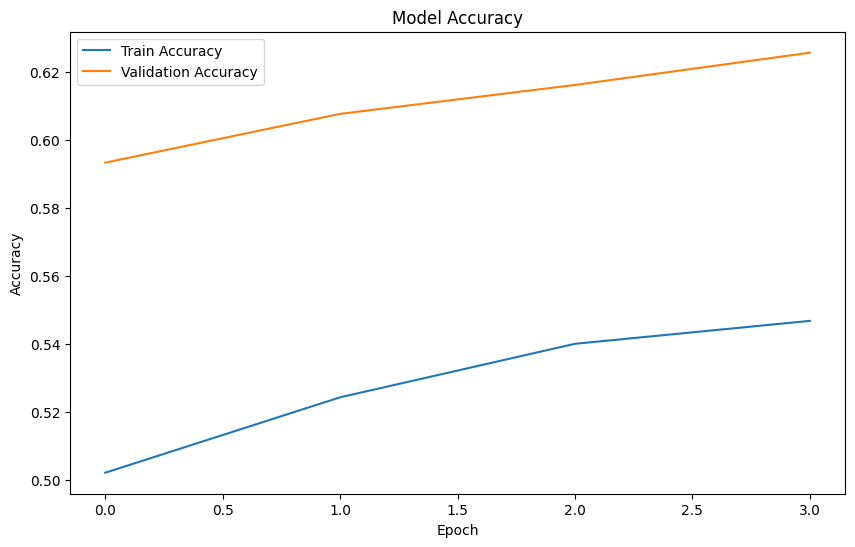

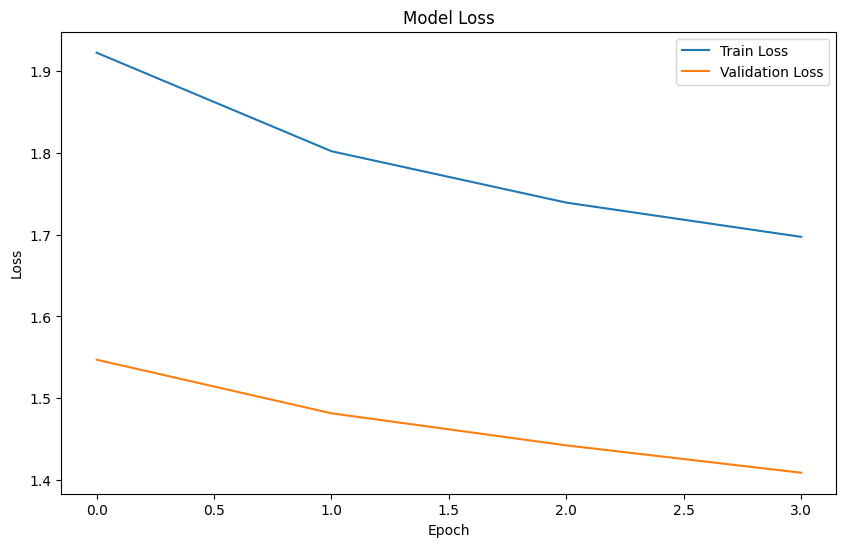

In [322]:
# Plot metrics
plot_history(history)

### Tips for fine tuning EfficientNet

On unfreezing layers:

- The `BatchNorm2d` layers need to be kept frozen.
If they are also turned to trainable, the
first epoch after unfreezing will significantly reduce accuracy.
- In some cases it may be beneficial to open up only a portion of layers instead of
unfreezing all. This will make fine tuning much faster when going to larger models like
B7.
- Each block needs to be all turned on or off. This is because the architecture includes
a shortcut from the first layer to the last layer for each block. Not respecting blocks
also significantly harms the final performance.

Some other tips for utilizing EfficientNet:

- Larger variants of EfficientNet do not guarantee improved performance, especially for
tasks with less data or fewer classes. In such a case, the larger variant of EfficientNet
chosen, the harder it is to tune hyperparameters.
- EMA (Exponential Moving Average) is very helpful in training EfficientNet from scratch,
but not so much for transfer learning.
- Do not use the RMSprop setup as in the original paper for transfer learning. The
momentum and learning rate are too high for transfer learning. It will easily corrupt the
pretrained weight and blow up the loss. A quick check is to see if loss (as categorical
cross entropy) is getting significantly larger than log(NUM_CLASSES) after the same
epoch. If so, the initial learning rate/momentum is too high.
- Smaller batch size benefit validation accuracy, possibly due to effectively providing
regularization.